<h1 style="color: orange;">CatBoost Model </h1>

<h2 style="color: green;">Installation Instructions</h2>
<p style="color: gray;">
Before getting started, please ensure that you have installed all the necessary libraries. You can install them by running the following commands in your terminal:
</p>
<pre style="color: gray;">
pip install catboost
pip install category_encoders
pip install scikit-learn
pip install pandas numpy matplotlib seaborn
</pre>

<h2 style="color: green;">Introduction</h2>
<p style="color: gray;">
In this notebook, we will build and evaluate a <strong>CatBoost</strong> model for the SBA Financial dataset. We will use <strong>target encoding</strong> to efficiently handle high-cardinality categorical features. CatBoost, a gradient boosting library that natively supports categorical variables, is particularly well-suited for this task.
</p>

<h2 style="color: green;">Objectives</h2>
<ul>
  <li style="color: gray;">Preprocess the data by imputing missing values and applying target encoding to high-cardinality features.</li>
  <li style="color: gray;">Construct a CatBoost classifier using a pipeline that integrates the preprocessing steps and target encoding.</li>
  <li style="color: gray;">Optimize the model using a two-stage hyperparameter tuning approach: RandomizedSearchCV followed by GridSearchCV.</li>
  <li style="color: gray;">Evaluate model performance using ROC AUC, confusion matrices, and detailed classification reports.</li>
</ul>

<h2 style="color: green;">Dataset</h2>
<p style="color: gray;">
The SBA Financial dataset includes several features, such as <em>State</em>, <em>BankState</em>, <em>ApprovalMonth</em>, and <em>NAICS_CODE</em>, many of which are high-cardinality categorical variables. The target variable is <em>MIS_Status</em>. Given the number of unique categories, target encoding is an efficient method to convert these features into numerical representations without an explosive increase in feature dimensions.
</p>

<h2 style="color: green;">Methodology</h2>
<p style="color: gray;">
The notebook is organized as follows:
</p>
<ol style="color: gray;">
  <li>Data Preprocessing: Imputation of missing values and target encoding of categorical features.</li>
  <li>Pipeline Construction: Integrating the preprocessing steps with the CatBoost classifier.</li>
  <li>Hyperparameter Tuning: First using RandomizedSearchCV to broadly explore parameter space, then GridSearchCV for fine-tuning.</li>
  <li>Model Evaluation: Assessing the model using ROC curves, confusion matrices, and other performance metrics.</li>
</ol>

<h2 style="color: green;">Let's Get Started!</h2>


<h3 style="color: Gray;"> 📌 1. Import libraries</h3>

In [10]:
#Data maipulation
import pandas as pd
import numpy as np
import pickle


#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

#Data modelization
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3 style="color: Gray;"> 📌 1. Load Data & Define Target </h3>

In [2]:
#Loading my dataset 
with open("/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/exp_data.pkl", "rb") as f:
    df = pickle.load(f, fix_imports=True)
    
print(df.head(2))
df.info()


  State    Zip BankState  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
0    IN  47711        OH        1997    84      4       1.0          0   
1    IN  46526        IN        1997    60      2       1.0          0   

   RetainedJob  FranchiseCode  UrbanRural  RevLineCr  LowDoc  \
0            0              0           0        0.0     1.0   
1            0              0           0        0.0     1.0   

   DisbursementGross  MIS_Status   GrAppv ApprovalMonth NAICS_CODE  
0            60000.0           0  60000.0             2         45  
1            40000.0           0  40000.0             2         72  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              899162 non-null  object 
 1   Zip                899164 non-null  object 
 2   BankState          897598 non-null  object 
 3   ApprovalFY      

In [ ]:

# --- Data Preparation ---
target = "MIS_Status"
X = df.drop(columns=[target])
y = df[target]

# Identify categorical columns (they will remain as strings/objects)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Fill missing values in categorical columns with the mode (most frequent value)
for col in cat_cols:
    # Compute the mode; if there are multiple modes, .mode()[0] gives the first one. This is equivalento to the most frequent value
    mode_value = X[col].mode()[0]
    X[col] = X[col].fillna(mode_value)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)


# Determine categorical feature indices (for CatBoost, indices are required)
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_cols]

<h3 style="color: Gray;"> 📌 2. RandomizedSearchCV </h3>

In [ ]:



# --- Define the CatBoost model ---
# Note: CatBoost can handle missing values and categorical features natively.
model = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=cat_feature_indices
)

# --- Define Hyperparameter Distributions for Randomized Search ---
param_distributions = {
    "iterations": np.arange(100, 300, 50),         # Values: 100, 150, ..., 250 (step of 50)
    "learning_rate": np.linspace(0.01, 0.1, 5),     # 5 equally spaced values between 0.01 and 0.1
    "depth": np.arange(3, 8, 1)                      # Values from 3 to 7 (inclusive), step of 1
}

# --- Run RandomizedSearchCV ---
rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=5,       # Adjust as needed for speed, this was the max we could do without crashing our vscode
    cv=3,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV:")
print(rs.best_params_)

# --- Evaluate the Best Model from Randomized Search ---
best_catboost_rs = rs.best_estimator_
y_pred = best_catboost_rs.predict(X_test)
y_pred_proba = best_catboost_rs.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC Score: {auc_score:.4f}")
print(report)
print("Confusion Matrix:")
print(cm)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters from RandomizedSearchCV:
{'learning_rate': 0.0775, 'iterations': 200, 'depth': 5}
AUC Score: 0.9740
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     74135
           1       0.89      0.79      0.83     15782

    accuracy                           0.95     89917
   macro avg       0.92      0.88      0.90     89917
weighted avg       0.94      0.95      0.94     89917

Confusion Matrix:
[[72551  1584]
 [ 3351 12431]]


<h3 style="color: Gray;"> 📌 3. GridSearchCV  </h3>

In [ ]:


# --- Define the CatBoost model ---
# Note: CatBoost can handle missing values and categorical features natively.
model = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=cat_feature_indices
)

param_grid = {
    "iterations": [200],                      # Only used the best value from randomized search to have a faster algorithm
    "learning_rate": [0.0775, 0.0930],          #Test only 2 combinations of hyperparameters
    "depth": [5]   }                           

gs = GridSearchCV(
    estimator=model,  # reuse the same CatBoostClassifier setup
    param_grid=param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best parameters from GridSearchCV:")
print(gs.best_params_)

best_catboost_gs = gs.best_estimator_
y_pred_gs = best_catboost_gs.predict(X_test)
y_pred_proba_gs = best_catboost_gs.predict_proba(X_test)[:, 1]
auc_score_gs = roc_auc_score(y_test, y_pred_proba_gs)
report_gs = classification_report(y_test, y_pred_gs)
print(f"AUC Score after Grid Search: {auc_score_gs:.4f}")
print(report_gs)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters from GridSearchCV:
{'depth': 5, 'iterations': 200, 'learning_rate': 0.093}
AUC Score after Grid Search: 0.9757
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     74135
           1       0.89      0.79      0.84     15782

    accuracy                           0.95     89917
   macro avg       0.92      0.89      0.90     89917
weighted avg       0.94      0.95      0.94     89917



<h3 style="color: Gray;"> 📌 4. Exporting our model </h3>

In [4]:
# Define the export directory.
import os
import pickle

export_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/'
os.makedirs(export_dir, exist_ok=True)  # create the directory if it doesn't exist

# Assuming your best grid model is stored in best_catboost_gs:
file_path = os.path.join(export_dir, 'catboost_best_grid_model.pkl')
with open(file_path, "wb") as f:
    pickle.dump(best_catboost_gs, f)
print(f"Exported grid model to {file_path}")


Exported grid model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/catboost_best_grid_model.pkl


<h3 style="color: Gray;"> 📌 5. DataViz of our model </h3>

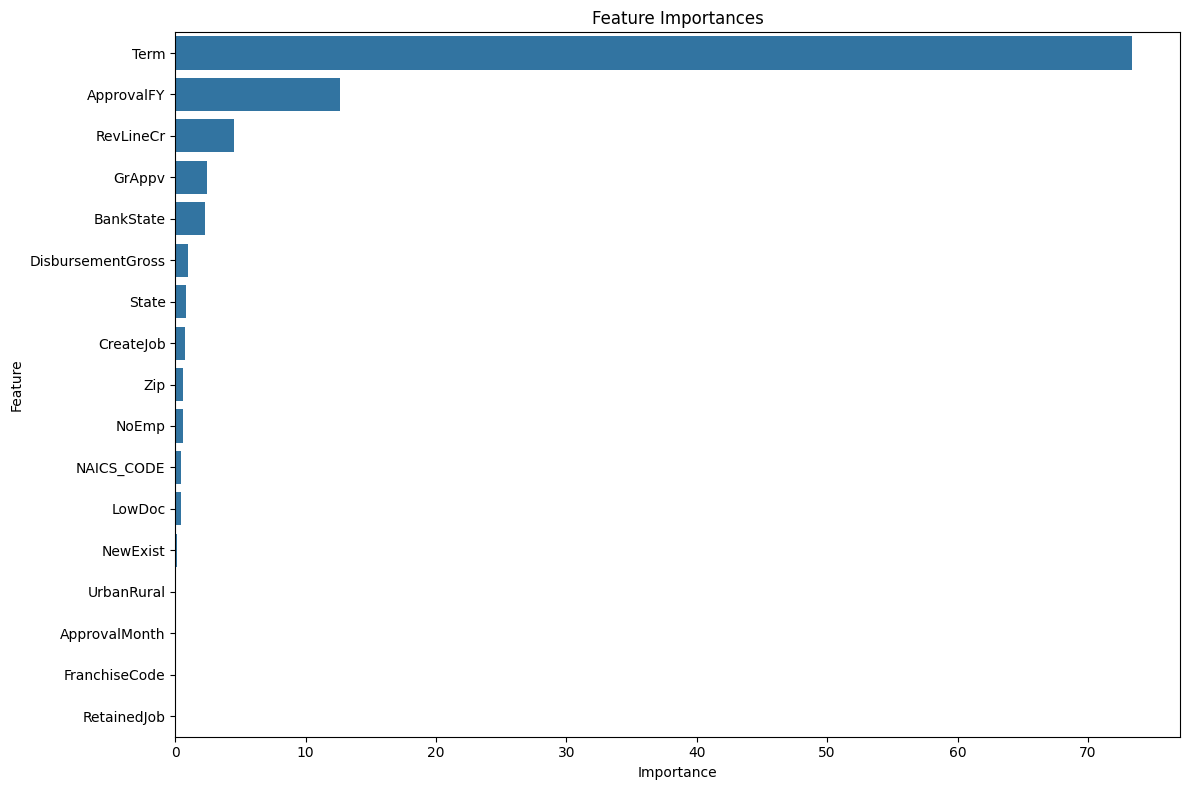

In [ ]:


# Get feature importances from the CatBoost model
feature_importances = best_catboost_gs.get_feature_importance()

# Here we assume that X_train.columns has the final feature names.
# (If your data underwent additional transformations, you may need to adjust.)
feat_imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


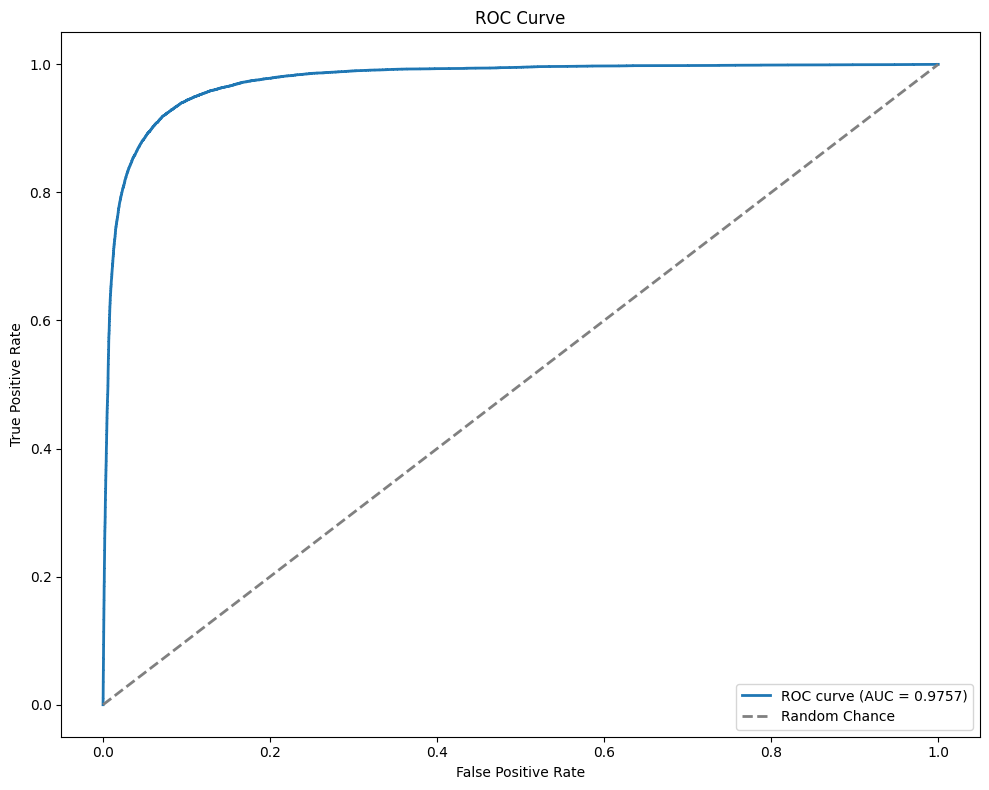

In [ ]:

# Get predicted probabilities for the positive class
y_pred_proba = best_catboost_gs.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc_value:.4f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


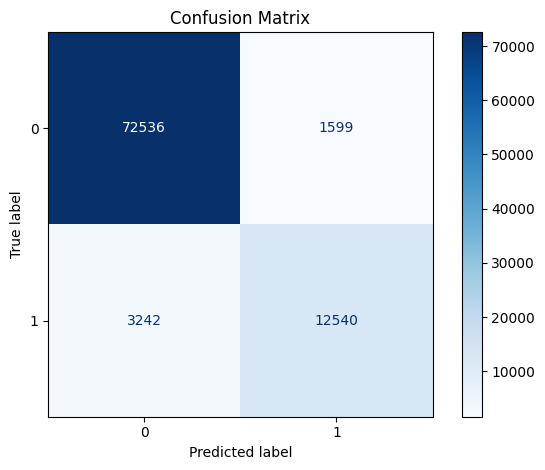

In [7]:

# Generate predictions
y_pred = best_catboost_gs.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


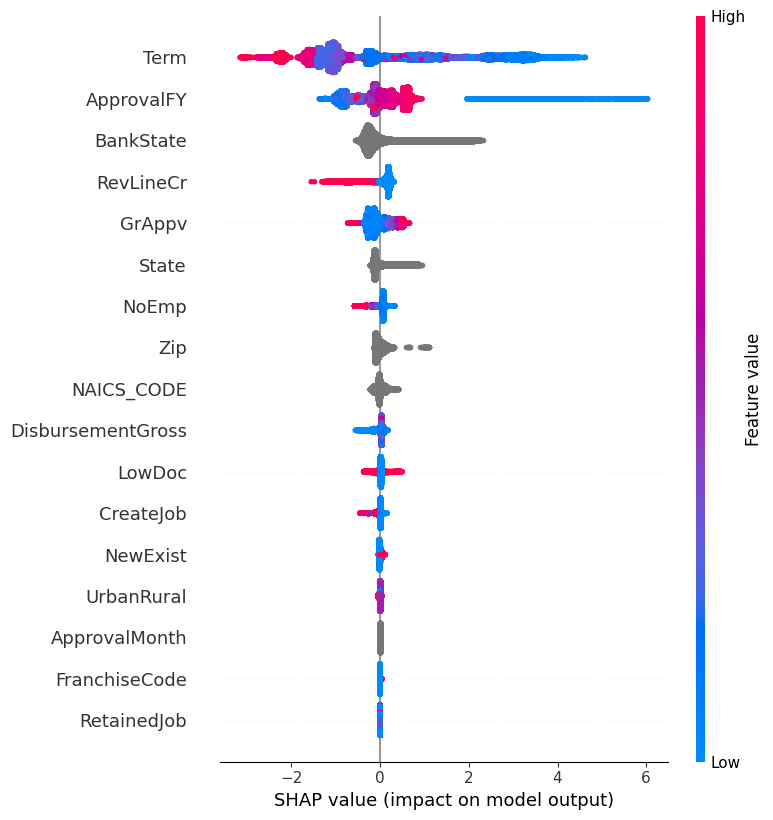

In [ ]:

# Create a Pool for the test data including the categorical feature indices
test_pool = Pool(X_test, label=y_test, cat_features=cat_feature_indices)

# Compute SHAP values; note that the output has shape (n_samples, n_features + 1)
# The last column is the base (expected) value, so we drop it.
shap_values = best_catboost_gs.get_feature_importance(test_pool, type="ShapValues")
shap_values = shap_values[:, :-1]

# Initialize JS visualization for SHAP (if using a notebook)
shap.initjs()

# Create a summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar", max_display=20)

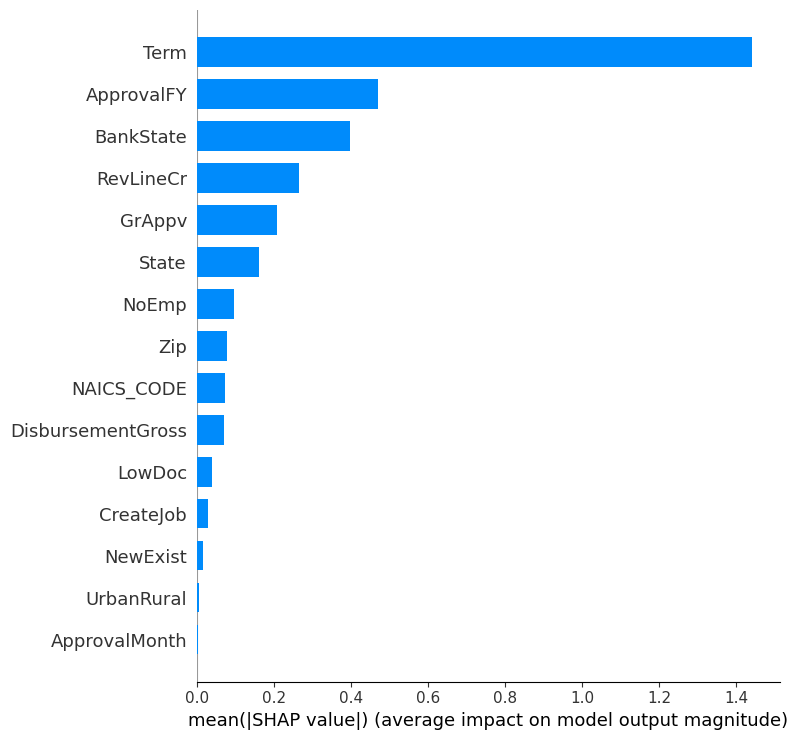

In [ ]:
#Testing another type of shap plot 

# Set a style and adjust the figure size.
plt.figure(figsize=(12, 8))

# Use a bar plot type and limit the number of displayed features.
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, 
                  plot_type="bar", max_display=15)